In [1]:
%matplotlib inline
import random
import pandas as pd
import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import math
import cvxpy as cp
def data_transform(df):
    """Normalize features."""
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

In [2]:
pd.__version__

'1.4.4'

In [3]:
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

In [4]:
train_url = 'adult/adult.data'
test_url = 'adult/adult.test'

original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

In [5]:
num_train = len(original_train)
original = pd.concat([original_train, original_test])
roc_original = original
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)
sensitive = original['Sex']
sensitive = sensitive.replace('Male', 0).replace('Female', 1)
# Redundant column
del original["Education"]
# Remove target variable
del original["Target"]
#del original["Sex"]


In [6]:
#binary_data = pd.get_dummies(original)
#data=pd.concat([binary_data, sensitive], axis=1)
data = data_transform(original)

train_data = data[:num_train].values
train_labels = labels[:num_train].values
test_data = data[num_train:].values
test_labels = labels[num_train:].values
p=train_data.shape[1]

In [7]:
def loss(X,Y,theta):
    eta=np.dot(X,theta)
    return -(np.dot(Y,eta)-np.sum(np.log(1+np.exp(eta))))

def f_grad(X,Y,theta):
    mu=1/(1+np.exp(-np.dot(X,theta)))
    return (np.dot(X.T,Y-mu))

def predict(theta,X):
    y =1/(1+np.exp(-np.dot(X,theta)))
    return np.array((y.T>0.5).reshape(-1)).astype(int)

def constraints(X,theta,z):
    length=z.shape
    #print(length)
    return np.array([np.dot(z,np.dot(X,theta))/length-c,-np.dot(z,np.dot(X,theta))/length-c]).reshape(-1)

def g_grad(X,z):
    length=z.shape
    return np.array([np.dot(z,X)/length,-np.dot(z,X)/length])

In [8]:
theta_0=np.ones(p)
Z=sensitive.values
Z=Z-Z.mean()
Z_train=Z[:num_train]
Z_test=Z[num_train:]
c=1.0

In [9]:
def determinstic(X,Y,z,T,C):
    lam=np.array([1.0,1.0])
    theta=theta_p=theta_pp=theta_0
    tau=C/math.sqrt(T)
    eta=C/math.sqrt(T)
    for i in range(T):
        u=2*(constraints(X,theta_p,z)+np.dot(g_grad(X,z),(theta-theta_p)))-(constraints(X,theta_pp,z)+np.dot(g_grad(X,z),(theta_p-theta_pp)))
        #u=2*constraints(X,theta,z)-constraints(X,theta_p,z)
        lam=lam+tau*u
        lam=np.maximum(0,lam)
        theta_pp=theta_p
        theta_p=theta
        theta=theta+eta*(f_grad(X,Y,theta)+np.dot(lam,g_grad(X,z)))
        if(i%10==0):
            pred=predict(theta,test_data)
            print(sklearn.metrics.accuracy_score(pred,test_labels))
            print(constraints(test_data,theta,Z_test))
        
    return theta
                                                                    

In [10]:
Beta=determinstic(train_data,train_labels,Z_train,200,0.001)

0.7000798476752043
[-1.55204179 -0.44795821]
0.7194275535900743
[-1.31392586 -0.68607414]
0.7275351636877342
[-1.29256741 -0.70743259]
0.7463914992936552
[-1.29049897 -0.70950103]
0.7676432651557029
[-1.29433003 -0.70566997]
0.7838584853510226
[-1.30060705 -0.69939295]
0.7959584792088938
[-1.30727041 -0.69272959]
0.8027148209569437
[-1.31416172 -0.68583828]
0.8079356304895277
[-1.32064772 -0.67935228]
0.8118051716725017
[-1.32678492 -0.67321508]
0.8159203980099502
[-1.33255808 -0.66744192]
0.8183158282660771
[-1.33804933 -0.66195067]
0.8202813095018734
[-1.3433006 -0.6566994]
0.8215097352742461
[-1.34831924 -0.65168076]
0.8221239481604324
[-1.353101 -0.646899]
0.8229224249124747
[-1.35764244 -0.64235756]
0.8247036422824151
[-1.36194444 -0.63805556]
0.8249493274368896
[-1.36601195 -0.63398805]
0.8256249616116946
[-1.36985275 -0.63014725]
0.8261163319206437
[-1.37347639 -0.62652361]


In [11]:
pred=predict(Beta,test_data)
print(sklearn.metrics.accuracy_score(pred,test_labels))

0.8263620170751182


In [12]:
def stochastic(X_data,Y_data,z_data,C,Batch,Epoch):
    lam=np.array([1.0,1.0])
    theta=theta_p=theta_pp=theta_0
    tau=C/math.sqrt(Epoch)
    eta=C/math.sqrt(Epoch)
    for i in range(Epoch):
        rd=random.randint(0,num_train)
        if rd+Batch>num_train:
            X=np.concatenate((X_data[rd:num_train],X_data[0:Batch+rd-num_train]),axis=0)
            Y=np.concatenate((Y_data[rd:num_train],Y_data[0:Batch+rd-num_train]),axis=0)
            z=np.concatenate((z_data[rd:num_train],z_data[0:Batch+rd-num_train]),axis=0)
        else:
            X=X_data[rd:rd+Batch]
            Y=Y_data[rd:rd+Batch]
            z=z_data[rd:rd+Batch]
        u=2*(constraints(X,theta_p,z)+np.dot(g_grad(X,z),(theta-theta_p)))-(constraints(X,theta_pp,z)+np.dot(g_grad(X,z),(theta_p-theta_pp)))
        lam=lam+tau*u
        lam=np.maximum(0,lam)
        theta_pp=theta_p
        theta_p=theta
        theta=theta+eta*(f_grad(X,Y,theta)+np.dot(lam,g_grad(X,z)))
        if i%100==0:
            pred=predict(theta,test_data)
            print(sklearn.metrics.accuracy_score(pred,test_labels))
            print(constraints(test_data,theta,Z_test))
        
    return theta

In [13]:
Beta=stochastic(train_data,train_labels,Z_train,0.1,200,10000)

0.645046373072907
[-1.02445119 -0.97554881]
0.7254468398747006
[-1.34603087 -0.65396913]
0.7188747619925066
[-1.34209045 -0.65790955]
0.734967139610589
[-1.3146722 -0.6853278]
0.7553590074319759
[-1.27642578 -0.72357422]
0.7722498618021006
[-1.29821184 -0.70178816]
0.7782077267981082
[-1.29073067 -0.70926933]
0.7879737116884712
[-1.31414437 -0.68585563]
0.798968122351207
[-1.31510736 -0.68489264]
0.8054173576561636
[-1.30980986 -0.69019014]
0.8064000982740618
[-1.32248722 -0.67751278]
0.8125422271359253
[-1.33998307 -0.66001693]
0.814446287083103
[-1.33028263 -0.66971737]
0.8161660831644247
[-1.33056416 -0.66943584]
0.8180087218229839
[-1.35726023 -0.64273977]
0.8204041520791107
[-1.35275586 -0.64724414]
0.817824457957128
[-1.32502156 -0.67497844]
0.8206498372335852
[-1.3768572 -0.6231428]
0.8244579571279406
[-1.37089929 -0.62910071]
0.8239665868189915
[-1.34984746 -0.65015254]
0.8228610036238561
[-1.35980145 -0.64019855]
0.8182544069774584
[-1.39091934 -0.60908066]
0.8244579571279406


In [15]:
beta = cp.Variable(p)
log_likelihood = cp.sum(
    cp.multiply(train_labels,train_data @ beta) - cp.logistic(train_data @ beta)
)
problem = cp.Problem(cp.Maximize(log_likelihood/len(data)))

In [16]:
problem.solve()

-0.279223838594197

In [59]:
b=beta.value

In [18]:
pred=predict(b,test_data)
print(sklearn.metrics.accuracy_score(pred,test_labels))

0.8309686137215159


In [19]:
print(np.sum((b-Beta)**2)/p)

0.20444120450966866


In [20]:
class center():
    def __init__(self,K,tau,eta):
        self.num=K
        self.tau=tau
        self.eta=eta
        self.lam=np.array([0.0,0.0])
        self.theta=np.zeros(p)
    def iteration(self):
        self.u=np.array([0.0,0.0])
        self.f_grad=np.zeros(p)
        self.g_grad=np.zeros([2,p])
    def get_data(self,u,f,g):
        self.u=self.u+u/self.num
        self.f_grad=self.f_grad+f/self.num
        self.g_grad=self.g_grad+g
    def get_theta(self):
        return self.theta
    def update(self):
        self.lam=self.lam+self.tau*self.u
        self.lam=np.maximum(0,self.lam)
        self.theta=self.theta+self.eta*(self.f_grad+np.dot(self.lam,self.g_grad))

In [21]:
class sever():
    def __init__(self,data,label,z_data,batch):
        self.data=data
        self.label=label
        self.z=z_data
        self.batch=batch
        self.len=data.shape[0]
        self.theta=self.theta_pp=self.theta_p=np.zeros(p)
    def get_data(self,theta):
        self.theta_pp=self.theta_p
        self.theta_p=self.theta
        self.theta=theta
    def send_u(self):
        return self.u
    def send_f(self):
        return self.f
    def send_g(self):
        return self.g
    def sample(self):
        rd=random.randint(0,self.len)
        if rd+self.batch>self.len:
            X=np.concatenate((self.data[rd:self.len],self.data[0:self.batch+rd-self.len]),axis=0)
            Y=np.concatenate((self.label[rd:self.len],self.label[0:self.batch+rd-self.len]),axis=0)
            z=np.concatenate((self.z[rd:self.len],self.z[0:self.batch+rd-self.len]),axis=0)
        else:
            X=self.data[rd:rd+self.batch]
            Y=self.label[rd:rd+self.batch]
            z=self.z[rd:rd+self.batch]
        h1=constraints(X,self.theta_p,z)+np.dot(g_grad(X,z),(self.theta-self.theta_p))
        h2=constraints(X,self.theta_pp,z)+np.dot(g_grad(X,z),(self.theta_p-self.theta_pp))
        self.u=2*h1-h2
        self.f=f_grad(X,Y,self.theta)
        self.g=g_grad(X,z)

In [22]:
def centrilized(X_data,Y_data,z_data,C,Batch,Epoch,K):
    tau=C/math.sqrt(Epoch)
    eta=C/math.sqrt(Epoch)
    Center=center(K,tau,eta)
    num=num_train-(num_train%K)
    data_part=np.split(X_data[0:num],K,axis=0)
    label_part=np.split(Y_data[0:num],K,axis=0)
    z_part=np.split(z_data[0:num],K,axis=0)
    Sever=[]
    for i in range(K):
        Sever.append(sever(data_part[i],label_part[i],z_part[i],Batch))
    for i in range(Epoch):
        for j in range(K):
            Sever[j].sample()
            Center.iteration()
            Center.get_data(Sever[j].send_u(),Sever[j].send_f(),Sever[j].send_g())
            Center.update()
            Sever[j].get_data(Center.get_theta())
        if i%10 == 0:
            Beta=Center.get_theta()
            pred=predict(Beta,test_data)
            print("predict error is {}, and ".format(sklearn.metrics.accuracy_score(pred,test_labels)))
            print("mean square error is {} ".format(np.sum((b-Beta)**2)/p))
            

In [23]:
centrilized(train_data,train_labels,Z_train,0.1,500,1000,10)

predict error is 0.7212087709600148, and 
mean square error is 0.8056381364338476 
predict error is 0.7361341440943431, and 
mean square error is 0.6853721741538158 
predict error is 0.751305202383146, and 
mean square error is 0.5988330138562287 
predict error is 0.7592899699035686, and 
mean square error is 0.5275871757424059 
predict error is 0.7651249923223389, and 
mean square error is 0.4687409049614836 
predict error is 0.7727412321110497, and 
mean square error is 0.418732350157146 
predict error is 0.7875437626681407, and 
mean square error is 0.3754831076854225 
predict error is 0.7866838646274799, and 
mean square error is 0.3385096478716382 
predict error is 0.7952214237454702, and 
mean square error is 0.30249423426124616 
predict error is 0.8000122842577237, and 
mean square error is 0.27235351149977116 
predict error is 0.8015478164731896, and 
mean square error is 0.24632550972862322 
predict error is 0.8025919783797064, and 
mean square error is 0.22291615504682177 
pr

predict error is 0.8303544008353295, and 
mean square error is 0.00035870409286757984 
predict error is 0.8292488176401941, and 
mean square error is 0.00036787613827007784 


0.20444120450966866


In [86]:
class agent():
    def __init__(self,data,label,z_data,batch,tau,eta,idx):
        self.data=data
        self.label=label
        self.z=z_data
        self.batch=batch
        self.len=data.shape[0]
        self.tau=tau
        self.eta=eta
        self.lam=np.array([0.0,0.0])
        self.theta=self.theta_h=self.theta_ph=self.theta_p=np.zeros(p)
        self.idx=idx
    def get_lam(self,LAM):
        self.lam=LAM[self.idx]
    def get_theta(self,THETA):
        self.theta_ph=self.theta_h
        self.theta_h=THETA[self.idx]
    def send_lam(self,LAM):
        LAM[self.idx]=self.lam
    def send_theta(self,THETA):
        THETA[self.idx]=self.theta

    def sample_lam(self):
        rd=random.randint(0,self.len)
        if rd+self.batch>self.len:
            X=np.concatenate((self.data[rd:self.len],self.data[0:self.batch+rd-self.len]),axis=0)
            z=np.concatenate((self.z[rd:self.len],self.z[0:self.batch+rd-self.len]),axis=0)
        else:
            X=self.data[rd:rd+self.batch]
            z=self.z[rd:rd+self.batch]
        h1=constraints(X,self.theta_h,z)+np.dot(g_grad(X,z),(self.theta-self.theta_h))
        h2=constraints(X,self.theta_ph,z)+np.dot(g_grad(X,z),(self.theta_p-self.theta_ph))
        self.lam=np.maximum(0,self.lam+self.tau*(2*h1-h2))
        
    def sample_theta(self):
        rd=random.randint(0,self.len)
        if rd+self.batch>self.len:
            X=np.concatenate((self.data[rd:self.len],self.data[0:self.batch+rd-self.len]),axis=0)
            Y=np.concatenate((self.label[rd:self.len],self.label[0:self.batch+rd-self.len]),axis=0)
            z=np.concatenate((self.z[rd:self.len],self.z[0:self.batch+rd-self.len]),axis=0)
        else:
            X=self.data[rd:rd+self.batch]
            Y=self.label[rd:rd+self.batch]
            z=self.z[rd:rd+self.batch]
        self.theta=self.theta_h+self.eta*(f_grad(X,Y,self.theta_h)+np.dot(self.lam,g_grad(X,z)))        
        
    def get_res(self):
        return self.lam, self.theta

In [97]:
def decentrilized(X_data,Y_data,z_data,C,Batch,Epoch,K):
    datalog=[]
    tau=C/math.sqrt(Epoch)
    eta=C/math.sqrt(Epoch)
    Center=center(K,tau,eta)
    num=num_train-(num_train%K)
    data_part=np.split(X_data[0:num],K,axis=0)
    label_part=np.split(Y_data[0:num],K,axis=0)
    z_part=np.split(z_data[0:num],K,axis=0)
    Agent=[]
    LAM=np.zeros([K,2])
    THETA=np.zeros([K,p])
    W=gossip_matrix(K)
    for i in range(K):
        Agent.append(agent(data_part[i],label_part[i],z_part[i],Batch,tau,eta,i))
    for i in range(Epoch):
        for j in range(K):
            Agent[j].send_lam(LAM)
        LAM=np.dot(W,LAM)
        for j in range(K):
            Agent[j].get_lam(LAM)
            Agent[j].sample_lam()
            Agent[j].send_theta(THETA)
        THETA=np.dot(W,THETA)
        for j in range(K):
            Agent[j].get_theta(THETA)
            Agent[j].sample_theta()
        if i%10 == 0:
            Beta=np.zeros(p)
            Lam=np.zeros(2)
            for j in range(K):
                tmp_lam,tmp_theta=Agent[j].get_res()
                Lam=Lam+tmp_lam/K
                Beta=Beta+tmp_theta/K
            pred=predict(Beta,test_data)
            datalog.append((sklearn.metrics.accuracy_score(pred,test_labels),np.sum((b-Beta)**2)/p))
    return datalog

In [98]:
def gossip_matrix(K):
    W=np.random.normal(loc=1,scale=1,size=(K,K))
    for i in range(K):
        temp=np.sum(W[i])
        W[i]=W[i]/temp
    return W

In [100]:
experiment=decentrilized(train_data,train_labels,Z_train,0.1,500,1000,10)

In [111]:
import matplotlib.pyplot as plt
mse,accurracy=[],[]
for i in range(len(experiment)):
    accurracy.append(experiment[i][0])
    mse.append(experiment[i][1])


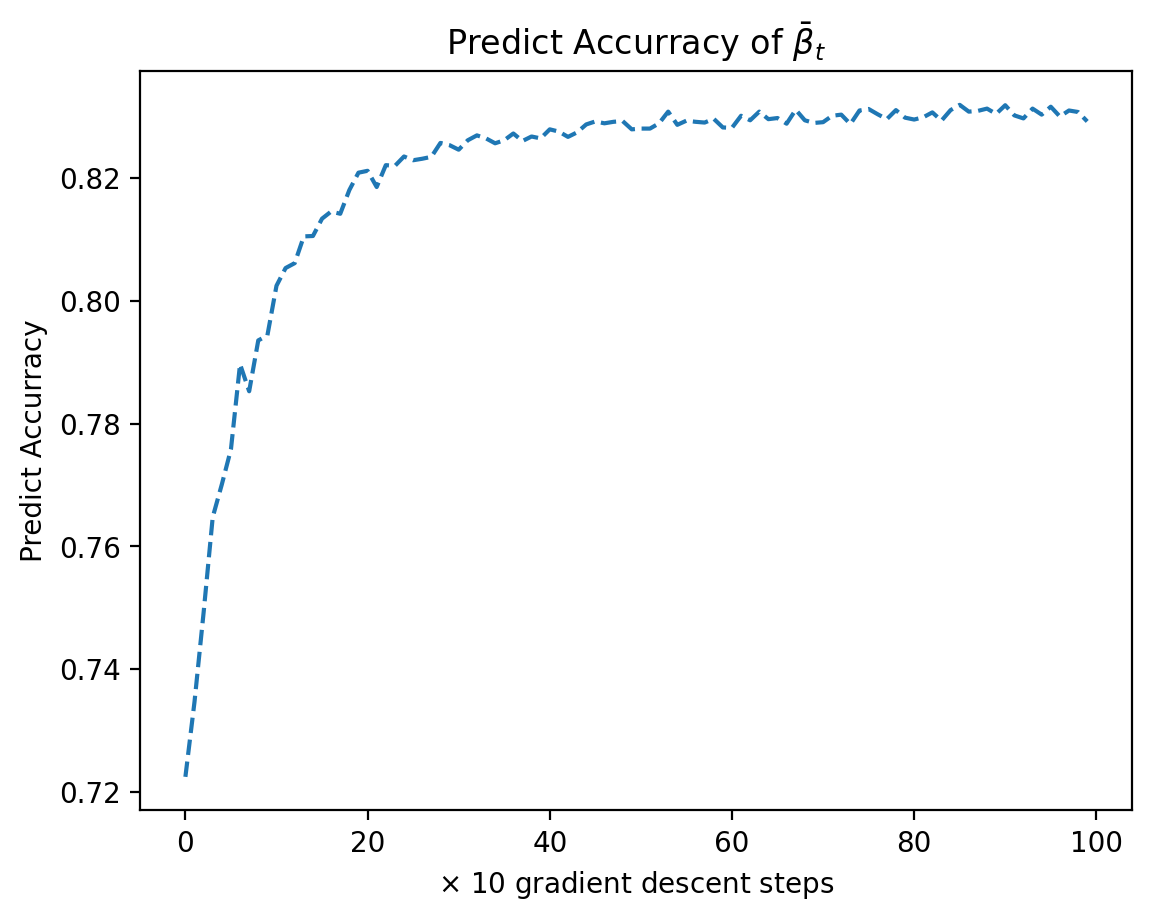

In [142]:
plt.figure(figsize=(6.4, 4.8), dpi=200.0)
plt.title("Predict Accurracy of $\\bar \\beta_t $")
plt.xlabel("$\\times$ 10 gradient descent steps")  
plt.ylabel("Predict Accurracy")  
plt.plot(accurracy, linestyle = '--')
plt.show()

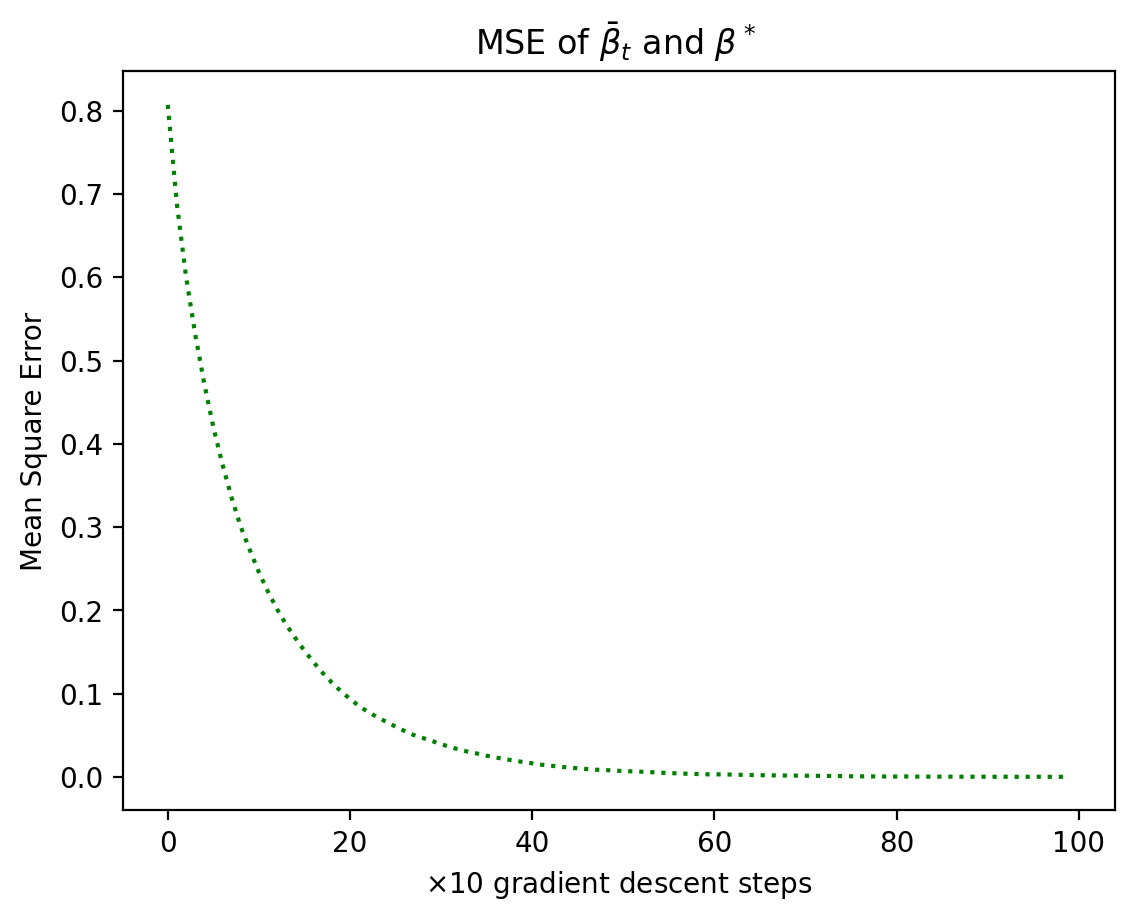

In [143]:
plt.figure(figsize=(6.4, 4.8), dpi=200.0)
plt.title("MSE of $\\bar \\beta_t $ and $ \\beta^*$ ")
plt.xlabel("$\\times$10 gradient descent steps")  
plt.ylabel("Mean Square Error") 
plt.plot(mse, linestyle = "dotted",color="g")
plt.show()